# Data Training, Regularizing, Feature Selection, and Testing

## Packages needed for analysis:

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

Import cleaned data on a Fips-date level

In [ ]:
import os


In [42]:
df = pd.read_csv("../Data/merged.csv")
print(df.head())
df['DATE']= pd.to_datetime(df['date'])
df["Date"] = df["DATE"].dt.date
df.dtypes

  state   fips county        date  cumulative_cases  cumulative_deaths  \
0    IL  17001  Adams  2020-03-20                 1                0.0   
1    IL  17001  Adams  2020-03-21                 1                0.0   
2    IL  17001  Adams  2020-03-22                 1                0.0   
3    IL  17001  Adams  2020-03-23                 1                0.0   
4    IL  17001  Adams  2020-03-24                 1                0.0   

   new_cases  new_deaths  new_cases_7avg  new_deaths_7avg  ...  \
0        1.0         0.0             1.0              0.0  ...   
1        0.0         0.0             0.0              0.0  ...   
2        0.0         0.0             0.0              0.0  ...   
3        0.0         0.0             0.0              0.0  ...   
4        0.0         0.0             0.0              0.0  ...   

   prev_day_adult_admit_unknown_7daysum  mask_mandate  retail_rec  \
0                                   NaN           NaN       -33.0   
1                   

state                       object
fips                         int64
county                      object
date                        object
cumulative_cases             int64
                         ...      
residential                float64
new doses                  float64
cumulative doses           float64
DATE                datetime64[ns]
Date                        object
Length: 89, dtype: object

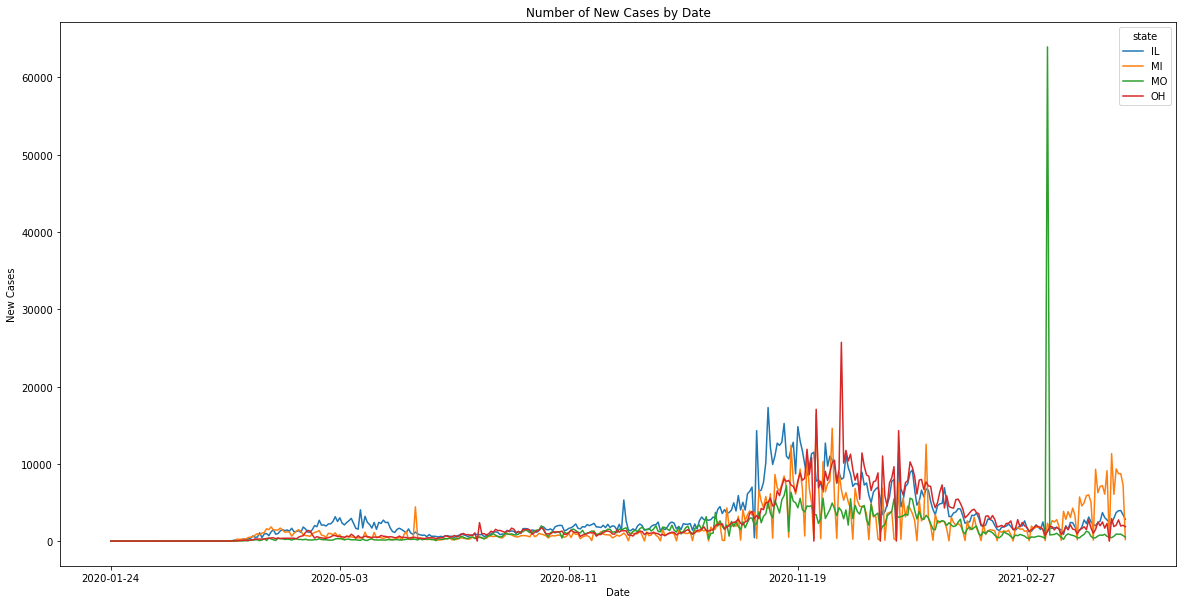

In [24]:
new_cases_state = df.groupby(["date","state"])["new_cases"].sum().unstack()
new_cases_state = new_cases_state.fillna(0)
new_cases_state
new_cases_state.plot(figsize=(20,10))
plt.title("Number of New Cases by Date")
plt.ylabel("New Cases")
plt.xlabel("Date")
plt.show()

Based on the above chart, clearly there is something wrong with March 8 for Missouri. According to research, they dumped probable cases into the system that day. Therefore, we will replace with the average of the previous 7 days.
This is also the case with Ohio December 8.

**Question: Do we need to adjust the 7 day average count with this information?**

In [43]:
from datetime import date
df.dtypes
# Since the data is on FIPS level, not sure best way to do this? 
df["rolling_mean"] = df["new_cases"].rolling(7).mean().shift(1)

#Missouri
mask1 = (df['Date'] == date(2021, 3, 8)) & (df.state == "MO")
#Ohio
mask2 = (df['Date'] == date(2020, 12, 8)) & (df.state == "OH")

df.loc[mask1, 'new_cases'] = df["rolling_mean"]
df.loc[mask2, 'new_cases'] = df["rolling_mean"]
df

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,...,grocery_pharm,parks,transit,workplace,residential,new doses,cumulative doses,DATE,Date,rolling_mean
0,IL,17001,Adams,2020-03-20,1,0.0,1.0,0.0,1.0,0.0,...,11.0,NaN,-7.0,-22.0,13.0,0.0,0.0,2020-03-20,2020-03-20,NaN
1,IL,17001,Adams,2020-03-21,1,0.0,0.0,0.0,0.0,0.0,...,-14.0,NaN,-30.0,-15.0,NaN,0.0,0.0,2020-03-21,2020-03-21,NaN
2,IL,17001,Adams,2020-03-22,1,0.0,0.0,0.0,0.0,0.0,...,-42.0,NaN,NaN,-25.0,NaN,0.0,0.0,2020-03-22,2020-03-22,NaN
3,IL,17001,Adams,2020-03-23,1,0.0,0.0,0.0,0.0,0.0,...,-20.0,NaN,-21.0,-29.0,14.0,0.0,0.0,2020-03-23,2020-03-23,NaN
4,IL,17001,Adams,2020-03-24,1,0.0,0.0,0.0,0.0,0.0,...,-20.0,NaN,NaN,-31.0,15.0,0.0,0.0,2020-03-24,2020-03-24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146197,OH,39175,Wyandot,2021-04-07,2230,53.0,2.0,0.0,2.0,0.0,...,NaN,NaN,11.0,-15.0,1.0,231.0,11852.0,2021-04-07,2021-04-07,2.428571
146198,OH,39175,Wyandot,2021-04-08,2236,53.0,6.0,0.0,2.0,0.0,...,NaN,NaN,11.0,-14.0,4.0,106.0,11958.0,2021-04-08,2021-04-08,2.285714
146199,OH,39175,Wyandot,2021-04-09,2239,53.0,3.0,0.0,2.0,0.0,...,NaN,NaN,18.0,-14.0,3.0,413.0,12371.0,2021-04-09,2021-04-09,2.000000
146200,OH,39175,Wyandot,2021-04-10,2241,53.0,2.0,0.0,2.0,0.0,...,NaN,NaN,28.0,-6.0,NaN,76.0,12447.0,2021-04-10,2021-04-10,2.285714


In [47]:
# From: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
import timesplit as ts

In [52]:
tscv = ts.TimeBasedCV(train_period=21,
                   test_period=7,
                   freq='days')
for train_index, test_index in tscv.split(df, date_column='DATE'):
    print(train_index, test_index)

Train period: 2020-01-24 - 2020-02-14 , Test period 2020-02-14 - 2020-02-21 # train records 21 , # test records 7
Train period: 2020-01-31 - 2020-02-21 , Test period 2020-02-21 - 2020-02-28 # train records 21 , # test records 7
Train period: 2020-02-07 - 2020-02-28 , Test period 2020-02-28 - 2020-03-06 # train records 21 , # test records 7
Train period: 2020-02-14 - 2020-03-06 , Test period 2020-03-06 - 2020-03-13 # train records 21 , # test records 40
Train period: 2020-02-21 - 2020-03-13 , Test period 2020-03-13 - 2020-03-20 # train records 54 , # test records 328
Train period: 2020-02-28 - 2020-03-20 , Test period 2020-03-20 - 2020-03-27 # train records 375 , # test records 961
Train period: 2020-03-06 - 2020-03-27 , Test period 2020-03-27 - 2020-04-03 # train records 1329 , # test records 1694
Train period: 2020-03-13 - 2020-04-03 , Test period 2020-04-03 - 2020-04-10 # train records 2983 , # test records 2124
Train period: 2020-03-20 - 2020-04-10 , Test period 2020-04-10 - 2020-04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 718,
 719,
 720,
 721,
 722,
 723,
 724,
 725,
 726,
 727,
 728,
 729,
 730,
 731,
 732,
 733,
 734,
 735,
 736,
 737,
 738,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1469,
 1470,
 1471,
 1472,
 1473,
 1474,
 1475,
 1476,
 1477,
 1478,
 1479,
 1480,
 1481,
 1482,
 1483,
 1484,
 1485,
 1486,
 1487,
 1488,
 1489,
 1815,
 1816,
 1817,
 1818,
 1819,
 1820,
 1821,
 1822,
 1823,
 1824,
 1825,
 1826,
 1827,
 1828,
 1829,
 1830,
 1831,
 1832,
 1833,
 1834,
 1835,
 2196,
 2197,
 2198,
 2199,
 2200,
 2201,
 2202,
 2203,
 2204,
 2205,
 2206,
 2207,
 2208,
 2209,
 2210,
 2211,
 2212,
 2213,
 2214,
 2215,
 2216,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2948,
 2949,

In [55]:
#If using sklearn - How do we account for keeping Fips together? I dont think this can:
# Here are some alternatives: https://stackoverflow.com/questions/51963713/cross-validation-for-grouped-time-series-panel-data

tss = TimeSeriesSplit(n_splits = 3)
# Probably will want to take more variables out
X = df.drop(labels=['new_cases'], axis=1)
y = df['new_cases']
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


Feature Selection Sources:
    https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d
    https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
Need to use a model to check which features? I would say Linear for simplicity but not sure that really works with this? So maybe logistic to start and check features and then we can compare other models? Not sure

In [64]:
# This normalize function is from Roberto's team from last year but I like how it reads in both training
# and testing at once. I think this makes a lot of sense especially if we use the Time-Based Cross Validation
# to create the training and testing where everything will need to be looped. 
# SO maybe put this into your pipeline file

def normalize(train_data, test_data, features):
    '''
    takes 2 datasets (testing data and trainning data) and a list of features to normalize 
    and changes columns to normalized new columns.
    '''
    
    scaler = StandardScaler()
    train = train_data.copy()
    test = test_data.copy()
    
    normal_train = scaler.fit_transform(train[features])
    normal_test = scaler.transform(test[features])
    
    for i, col in enumerate(features):
        train.loc[:, col] = normal_train[:, i]
        test.loc[:, col] = normal_test[:, i]

    return train, test